# Análisis de Series Temporales
## Laboratorio 1
### Mario Agustín Sgró

In [1]:
from scipy import stats
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set_context('notebook') 
sns.set_style('ticks')
red  = '#D62728'
blue = '#1F77B4'

plt.rcParams['figure.figsize'] = [15, 10]

## Data: Consumos de minutos en telefonía móvil

En este laboratorio utilizaremos los datos de minutos consumidos (salientes) en telefonía móvil, para el periodo 2013-01 hasta 2019-01, medidos trimestralmente.

In [3]:
tel = pd.read_csv('./datasets/Telefonia_movil.csv', dtype={})

In [4]:
tel.head(5)

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
0,2013,1,8.785.943,6582117,15368060,Ene-Mar 2013
1,2013,2,9.512.689,7108640,16621329,Abr-Jun 2013
2,2013,3,10.315.484,7335154,17650638,Jul-Sept 2013
3,2013,4,9.809.515,6250549,16060064,Oct-Dic 2013
4,2014,1,10.128.751,5799223,15927974,Ene-Mar 2013


In [5]:
tel['Minutos pospago salientes (miles)']=tel['Minutos pospago salientes (miles)'].apply(lambda x: x.replace('.',''))
tel['Minutos pospago salientes (miles)']=tel['Minutos pospago salientes (miles)'].astype('int')

In [6]:
tel.head(5)

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
0,2013,1,8785943,6582117,15368060,Ene-Mar 2013
1,2013,2,9512689,7108640,16621329,Abr-Jun 2013
2,2013,3,10315484,7335154,17650638,Jul-Sept 2013
3,2013,4,9809515,6250549,16060064,Oct-Dic 2013
4,2014,1,10128751,5799223,15927974,Ene-Mar 2013


Reacomodamos la base de datos para quedarnos con los datos que nos interesan, e identificar el periodo con los cuartiles de los años.

In [7]:
tel['Prd']=tel['Año'].astype(str) + 'Q' +tel['Trimestre'].astype(str) 

In [8]:
tel.index=pd.PeriodIndex(tel['Prd'].values, freq='Q')

In [9]:
tel.drop(['Año','Trimestre','Prd','Total de minutos salientes (miles)','Periodo'], axis=1, inplace=True)
tel.columns=['MinPosPago','MinPrePago']

In [10]:
tel.head(5)

,MinPosPago,MinPrePago
2013Q1,8785943,6582117
2013Q2,9512689,7108640
2013Q3,10315484,7335154
2013Q4,9809515,6250549
2014Q1,10128751,5799223


In [11]:
print(tel.shape)
display(tel.head(5))
display(tel.describe())

(25, 2)


,MinPosPago,MinPrePago
2013Q1,8785943,6582117
2013Q2,9512689,7108640
2013Q3,10315484,7335154
2013Q4,9809515,6250549
2014Q1,10128751,5799223


,MinPosPago,MinPrePago
count,2.500000e+01,2.500000e+01
mean,1.235930e+07,6.562909e+06
std,2.085582e+06,5.168604e+05
min,8.785943e+06,5.380710e+06
25%,1.082146e+07,6.250549e+06
50%,1.190507e+07,6.579819e+06
75%,1.424022e+07,7.077838e+06
max,1.596076e+07,7.335154e+06


Le echamos un vistazo a los datos

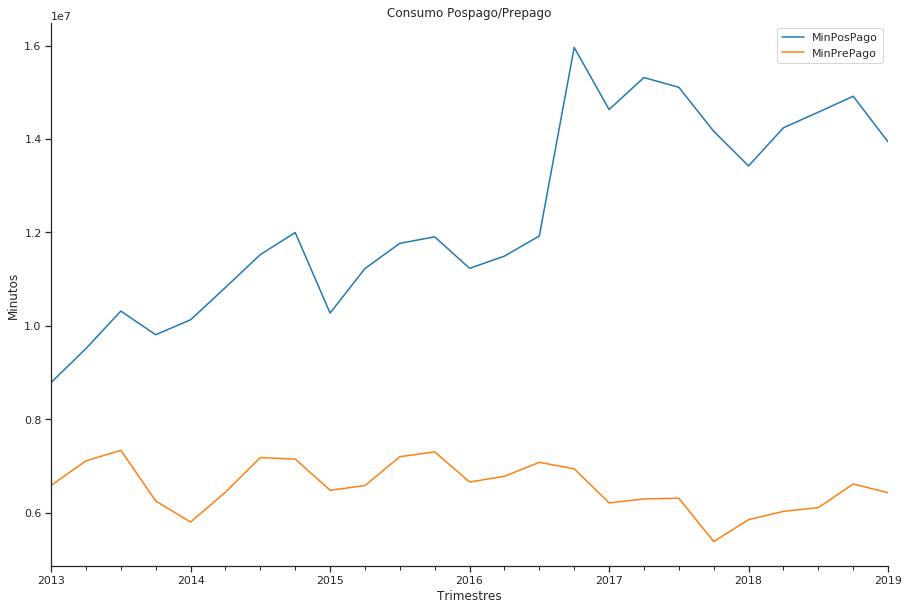

In [12]:
ax = tel.plot()

ax.set_xlabel('Trimestres')
ax.set_ylabel('Minutos')
ax.set_title('Consumo Pospago/Prepago')
sns.despine()
plt.show()

## Naïve (Random Walk)

In [13]:
h = 4
test = pd.period_range(start=tel.index[-1]+1, periods=h, freq='Q')

pred1=pd.Series(np.repeat(tel.MinPosPago.iloc[-1], h), index=test)
pred2=pd.Series(np.repeat(tel.MinPrePago.iloc[-1], h), index=test)

display(pred1.head(5))
display(pred2.head(5))

pred = pd.concat([pred1,pred2], axis=1)
pred.columns=['Pred-MinPosPago','Pred-MinPrePago']
pred.head()

2019Q2    13937271
2019Q3    13937271
2019Q4    13937271
2020Q1    13937271
Freq: Q-DEC, dtype: int64

2019Q2    6427084
2019Q3    6427084
2019Q4    6427084
2020Q1    6427084
Freq: Q-DEC, dtype: int64

,Pred-MinPosPago,Pred-MinPrePago
2019Q2,13937271,6427084
2019Q3,13937271,6427084
2019Q4,13937271,6427084
2020Q1,13937271,6427084


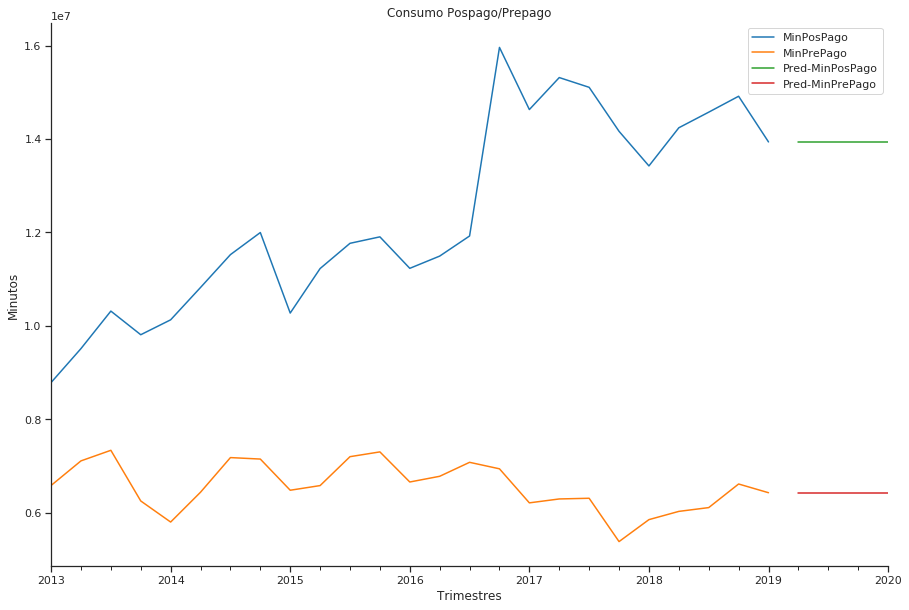

In [14]:
ax = tel.plot()
pred.plot(ax=ax)

ax.set_xlabel('Trimestres')
ax.set_ylabel('Minutos')
ax.set_title('Consumo Pospago/Prepago')
sns.despine()
plt.show()

Agregamos el intervalo de confianza para las predicciones (solo para los minutos pospago, como ejemplo)

In [15]:
pos = tel.MinPosPago

In [16]:
resid = pos - pos.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

1111026.926

In [17]:
intv = pd.concat([pred1-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred1-stats.norm.ppf(0.025)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2019Q2,1.175970e+07,1.611484e+07
2019Q3,1.085772e+07,1.701682e+07
2019Q4,1.016560e+07,1.770894e+07
2020Q1,9.582125e+06,1.829242e+07


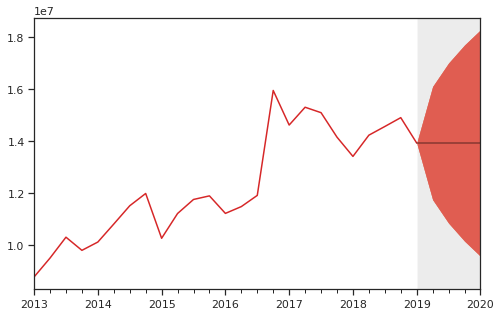

In [18]:
from plotting import fanchart

point_pred = (intv[0]+intv[1])/2

fig, ax = fanchart(pos,point_pred,intv,intv,intv)

plt.show()

Como las series parecen no presentar comportamientos estacionales no aplicamos _Seasonal Naïve_.

## Drift

In [19]:
pred1

2019Q2    13937271
2019Q3    13937271
2019Q4    13937271
2020Q1    13937271
Freq: Q-DEC, dtype: int64

In [20]:
h = 4
test = pd.period_range(start=tel.index[-1], periods=h, freq='Q')

i = np.arange(1,5)
suma = (tel.MinPosPago.iloc[-1] - tel.MinPosPago.iloc[0])/(len(tel.index-1))
pred1 = pd.Series(tel.MinPosPago.iloc[-1] + i*suma, index=test)

suma = (tel.MinPrePago.iloc[-1] - tel.MinPrePago.iloc[0])/(len(tel.index-1))
pred2 = pd.Series(tel.MinPrePago.iloc[-1] + i*suma, index=test)

display(pred1.head(5))
display(pred2.head(5))

pred = pd.concat([pred1,pred2], axis=1)
pred.columns=['Pred-MinPosPago','Pred-MinPrePago']
pred.head()

2019Q1    14143324.12
2019Q2    14349377.24
2019Q3    14555430.36
2019Q4    14761483.48
Freq: Q-DEC, dtype: float64

2019Q1    6420882.68
2019Q2    6414681.36
2019Q3    6408480.04
2019Q4    6402278.72
Freq: Q-DEC, dtype: float64

,Pred-MinPosPago,Pred-MinPrePago
2019Q1,14143324.12,6420882.68
2019Q2,14349377.24,6414681.36
2019Q3,14555430.36,6408480.04
2019Q4,14761483.48,6402278.72


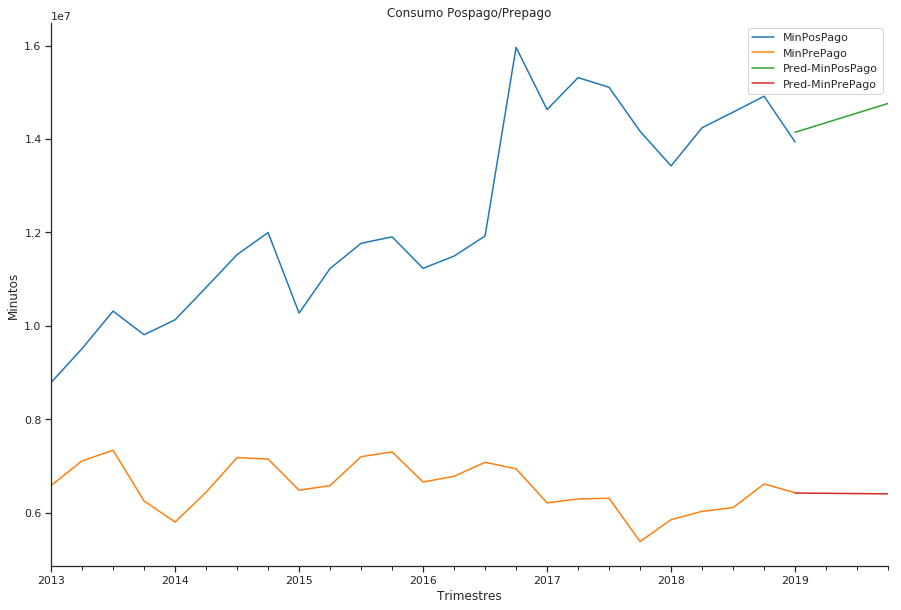

In [21]:
ax = tel.plot()
pred.plot(ax=ax)

ax.set_xlabel('Trimestres')
ax.set_ylabel('Minutos')
ax.set_title('Consumo Pospago/Prepago')
sns.despine()
plt.show()

## Simple Exponential Smoothing

In [22]:
pos = tel.MinPosPago

In [23]:
model_ses = sm.tsa.SimpleExpSmoothing(pos).fit()

In [24]:
fitted_ses = model_ses.fittedvalues

In [25]:
mse_ses = sm.tools.eval_measures.mse(pos,fitted_ses)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses))

 In-sample fit:
 MSE               1135757355867.054


In [26]:
N = len(pos)
loglik_ses = -(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses)
aic_ses = -2*loglik_ses+2*3
bic_ses = -2*loglik_ses+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

 Log-likelihood    -382.452
 AIC               770.905
 BIC               774.562


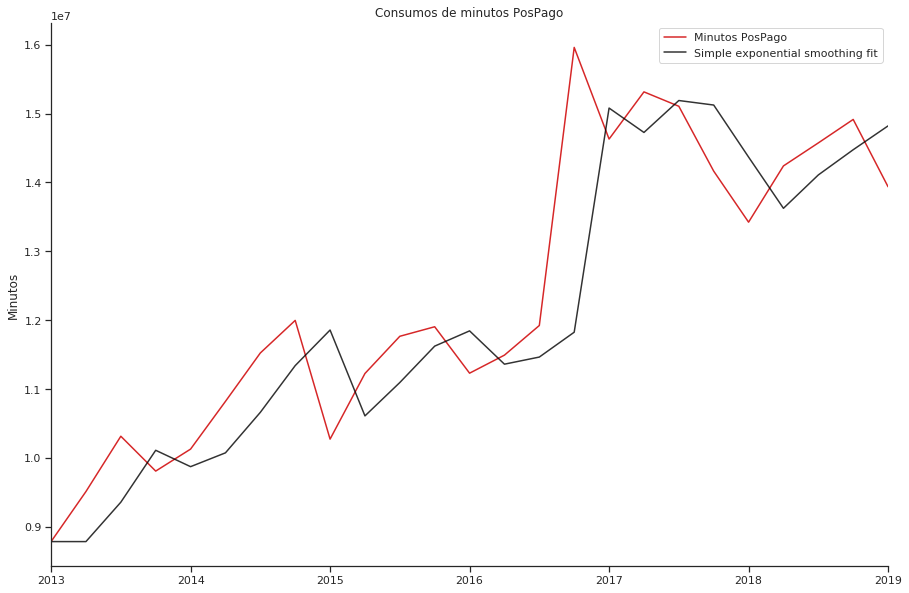

In [27]:
ax = pos.plot(color=red, label='Minutos PosPago')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Minutos')
ax.set_title('Consumos de minutos PosPago')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

In [28]:
resid = (pos - fitted_ses)/pos

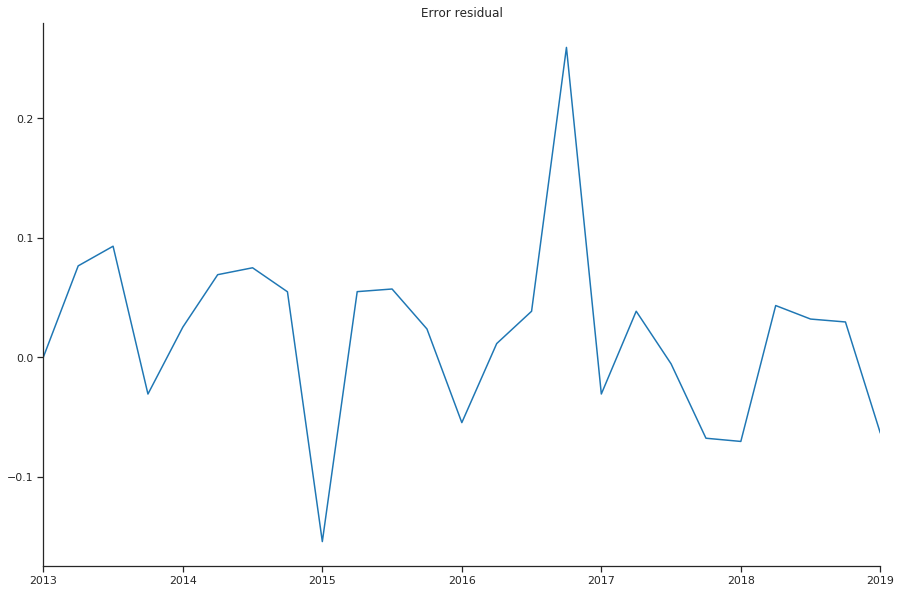

In [29]:
fig, ax = plt.subplots()
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Error residual')
sns.despine()
plt.show()

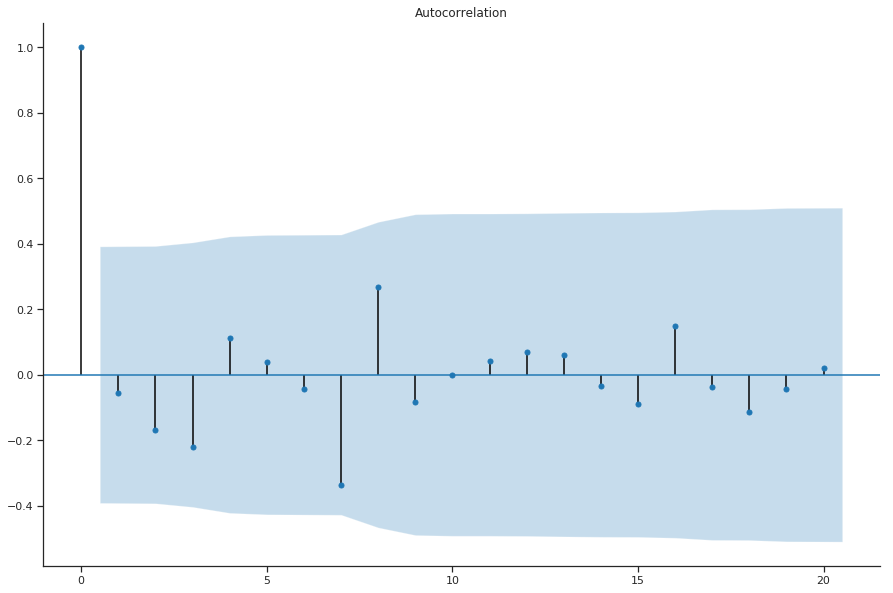

In [30]:
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(resid, lags=20, ax=ax)
sns.despine()
plt.show()

### Predicciones
Aplicamos Simple Exponential Smoothing para hacer las predicciones para los próximos 4 trimestres empleando dos métodos:
    - Expanding window: en cada paso, se extiende el training set
    - Rolling window: en cada paso, se usan solo las últimas n observaciones (los datos del pasado -lejano- pierden relevancia y por eso se ignoran). En este caso utilizamos 8 trimestres.


/home/marioagustin/MiniConda/envs/diplodatos/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


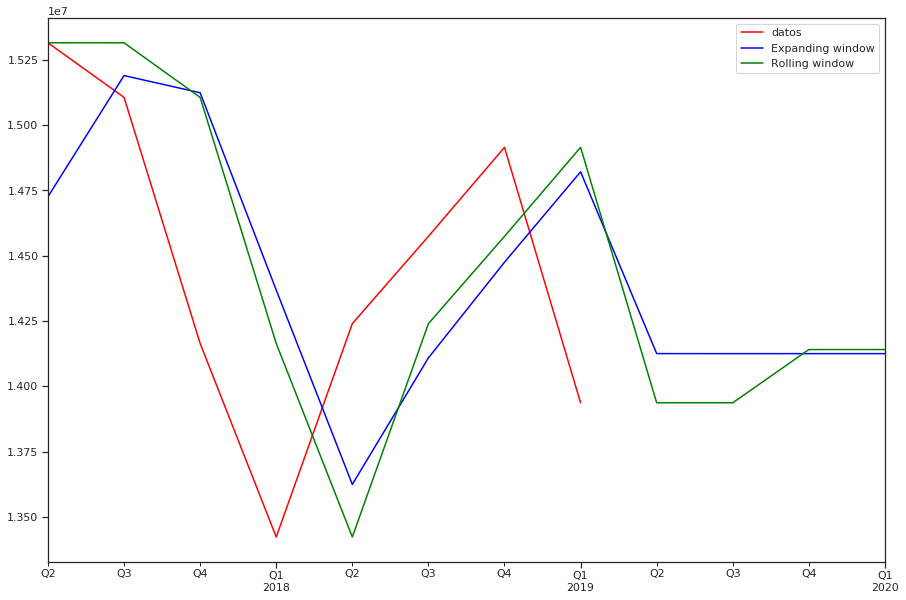

In [31]:
h = 4
w = h*2

model = sm.tsa.SimpleExpSmoothing

pred_index = pos.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)

orig_exp = None
orig_roll = None

for i in range(0,h):
    current_exp = pd.concat([pos, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    
    current_roll = pd.concat([pos, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
        
ax = pos[-w:].plot(color='red',label="datos");
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue',label="Expanding window");
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green',label="Rolling window");
ax.legend();